In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
print(tf.__version__)

2.3.1


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   cache_dir = '~/shared',
                                   cache_subdir = '',
                                   untar=True)

In [3]:
# size in MB
!du -mh $data_dir

48M	/home/jupyter-raoul.grouls/shared/flower_photos/dandelion
35M	/home/jupyter-raoul.grouls/shared/flower_photos/daisy
40M	/home/jupyter-raoul.grouls/shared/flower_photos/roses
54M	/home/jupyter-raoul.grouls/shared/flower_photos/sunflowers
55M	/home/jupyter-raoul.grouls/shared/flower_photos/tulips
230M	/home/jupyter-raoul.grouls/shared/flower_photos


In [4]:
# amount of files
!find $data_dir -type f | wc -l

3671


In [5]:
batch_size = 32
img_height = 227
img_width = 227

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)
nclasses = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for x, y in train_ds:
    print(x.shape)
    print(y.shape)
    break

(32, 227, 227, 3)
(32,)


# Explore dataset

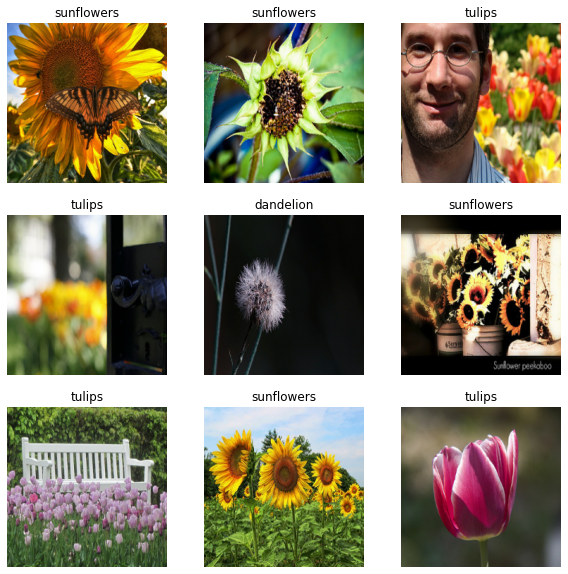

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
[img_height, img_width, 3]

[227, 227, 3]

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Input, Dropout, GlobalAveragePooling2D

model = tf.keras.Sequential([
    Input(shape=[img_height, img_width, 3]),
    Rescaling(1./255),
    
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu', name='c1'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s2'),
    
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name='c3'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s4'),
    
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c5'),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c6'),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c7'),
    
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s8'),
    
    Flatten(),
    Dense(2000, activation='relu', name='f9'),
    Dropout(0.5),
    Dense(1000, activation='relu', name='f10'),
    Dropout(0.5),
    Dense(nclasses, activation='softmax', name='out')
])

model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 227, 227, 3)       0         
_________________________________________________________________
c1 (Conv2D)                  (None, 55, 55, 96)        34944     
_________________________________________________________________
s2 (MaxPooling2D)            (None, 27, 27, 96)        0         
_________________________________________________________________
c3 (Conv2D)                  (None, 27, 27, 256)       614656    
_________________________________________________________________
s4 (MaxPooling2D)            (None, 13, 13, 256)       0         
_________________________________________________________________
c5 (Conv2D)                  (None, 13, 13, 384)       885120    
_________________________________________________________________
c6 (Conv2D)                  (None, 13, 13, 384)       1

In [ ]:
%%time
history = model.fit(train_ds, validation_data=valid_ds, epochs=25)

Epoch 1/25
92/92 [==============================] - 68s 736ms/step - loss: 1.6777 - accuracy: 0.2306 - val_loss: 1.6031 - val_accuracy: 0.2398
Epoch 2/25
10/92 [==>...........................] - ETA: 51s - loss: 1.5902 - accuracy: 0.2688

In [ ]:
model.evaluate(valid_ds)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense
from tensorflow.keras import Model

def build_model(hp):
    input = Input(shape = [180,180, 3])
    
    x = Rescaling(1./255)(input)
    
    x=Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu', name='c1')(x)
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s2')(x)
    
    filters1 = hp.Int('filters1', 192, 288, 32)
    x=Conv2D(filters=filters1, kernel_size=(5,5), strides=(1,1),padding='same', activation='relu', name='c3')(x)
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s4')(x)
    
    filters2 = hp.Int('filters2', 256, 448, 32)
    x=Conv2D(filters=filters2, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c5')(x)
    x=Conv2D(filters=filters2, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c6')(x)
    x=Conv2D(filters=filters1, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu', name='c7')(x)
    
    x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='s8')(x)
    
    x=Flatten()(x)
    units = hp.Int('units', 512, 4096, 256)
    x=Dense(units, activation='relu', name='f9')(x)
    
    drops = hp.Float('drops', 0.1, 0.5)
    x=Dropout(drops)(x)
    x=Dense(units, activation='relu', name='f10')(x)
    x=Dropout(drops)(x)
    output=Dense(nclasses, activation='softmax', name='out')(x)
    
    lr = hp.Float('lr', 1e-5, 1e-2)

    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=lr), metrics=['accuracy'])
    return model

In [ ]:
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner/

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    directory='ktuner',
    project_name='mnist'
)
tuner.search(train_ds, validation_data = valid_ds, verbose=1)

In [ ]:
class InceptionUnit(tf.keras.layers.Layer):
    def __init__(self, conv1_filters, conv3_filters, conv5_filters, conv1_max_filters, pre_conv3_filters, 
                 pre_conv5_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=conv1_filters, kernel_size=1, strides=1, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=conv3_filters, kernel_size=3, strides=1, padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=conv5_filters, kernel_size=5, strides=1, padding='same')
        self.conv1_max = tf.keras.layers.Conv2D(filters=conv1_max_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv3 = tf.keras.layers.Conv2D(filters=pre_conv3_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv5 = tf.keras.layers.Conv2D(filters=pre_conv5_filters, kernel_size=1, strides=1, padding='same')
        self.pre_conv1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        pre_c3 = self.pre_conv3(inputs)
        c3 = self.conv3(pre_c3)
        pre_c5 = self.pre_conv5(inputs)
        c5 = self.conv5(pre_c5)
        pre_c1m = self.pre_conv1(inputs)
        c1m = self.conv1_max(pre_c1m)
        out = tf.concat([c1, c3, c5, c1m], axis=3)
        return out

In [ ]:
model = tf.keras.Sequential([
    Input(shape=[img_height, img_width, 3]),
    Rescaling(1./255),
    Conv2D(64, 7, strides=2, padding='same'),
    MaxPool2D(3, strides=2, padding='same'),
    
    Conv2D(64, 1, strides=1, padding='same'),
    Conv2D(192, 3, strides=1, padding='same'),
    MaxPool2D(3, strides=2, padding='same'),
    
    InceptionUnit(64, 128, 32, 32, 96, 16),
    InceptionUnit(128, 192, 96, 64, 128, 32),
    InceptionUnit(128, 192, 96, 64, 128, 32),
    MaxPool2D(3, strides=2, padding='same'),
    InceptionUnit(192, 208, 48, 64, 96, 16),
    MaxPool2D(3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(nclasses, activation='sigmoid'),
    
])

model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

In [ ]:
%%time
history = model.fit(train_ds, validation_data=valid_ds, epochs=5)

In [ ]:
def build_model(hp):
    input = Input(shape = [img_height,img_width, 3])
    
    x = Rescaling(1./255)(input)
    
    filters = hp.Int('filters', 16, 32, 4)
    x = Conv2D(filters, 3, activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    for i in range(hp.Int('conv_layers', 0, 3)):
        x = Conv2D(filters, 3, activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 320, 64)
    #act = hp.Choice('act', ['relu', 'elu', 'selu'])
    act = 'relu'

    x = Dense(units, activation=act)(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation=act)(x)
    
    output = Dense(5, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model